In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import seaborn as sns
import shutil
import gc

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, balanced_accuracy_score, get_scorer_names
from sklearn.utils import class_weight
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE, ADASYN
import xgboost as xgb
from lightgbm import LGBMClassifier

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! cp /content/drive/MyDrive/inf0619_trabalho_final/features/convnextXLarge_val.parquet /content/
! cp /content/drive/MyDrive/inf0619_trabalho_final/features/convnextXLarge_train.parquet /content/
! cp /content/drive/MyDrive/inf0619_trabalho_final/features/convnextXLarge_test.parquet /content/

In [4]:
train_features = pd.read_parquet("/content/convnextXLarge_train.parquet")
train_features

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_2039,f_2040,f_2041,f_2042,f_2043,f_2044,f_2045,f_2046,f_2047,y_label
0,0.782490,0.096954,0.262080,0.174282,-0.383177,0.104748,0.793320,0.775638,-0.223562,-0.396620,...,-0.317172,-0.119336,0.818237,0.200412,-0.663302,-0.748892,-0.571000,1.043246,0.003858,0
1,0.467280,0.101803,0.288125,0.040087,-0.410418,-0.237152,0.341802,0.433974,-0.192482,0.037039,...,-0.266931,-0.290033,0.212844,0.351380,-0.399469,-0.499037,-0.221880,0.537133,0.417149,0
2,0.563512,0.124270,0.226611,-0.317395,-0.197211,-0.133061,0.081092,0.485044,-0.144118,0.179420,...,-0.046226,0.087496,0.694079,-0.119628,-0.022707,-0.252247,0.190731,0.298398,-0.074016,0
3,0.383937,0.133545,0.356170,0.253072,-0.400867,0.311865,0.506546,0.474224,-0.158302,-0.186319,...,-0.432675,-0.232704,0.153082,0.503808,-0.302560,-0.505552,-0.094205,0.752288,0.403607,0
4,0.539969,0.056070,0.322341,0.298526,-0.480753,0.181412,0.406155,0.609025,-0.085398,-0.393190,...,-0.245263,-0.200124,0.673855,0.247383,-0.650726,-0.496275,-0.265739,0.853555,0.260939,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35042,0.722012,0.042699,0.231991,-0.113181,-0.224732,0.285437,0.714974,0.477097,-0.136725,-0.361651,...,-0.293015,0.138114,1.075602,0.371254,-0.496169,-0.480217,-0.472666,1.221435,-0.078261,0
35043,0.346065,0.004064,0.327129,0.046828,-0.418746,-0.046233,0.164071,0.316719,-0.122912,-0.151308,...,-0.263095,-0.154106,0.457960,0.195209,-0.304282,-0.428850,-0.348681,1.173619,0.139302,0
35044,0.625576,0.118291,0.466354,-0.180872,-0.424132,0.363793,0.622168,0.332305,-0.072464,-0.151749,...,-0.207177,-0.180458,0.559305,-0.098789,-0.488502,-0.570178,0.593500,0.914358,-0.163439,0
35045,0.488206,0.091432,0.250394,-0.064005,-0.341453,0.255575,0.530682,0.545281,-0.220475,-0.172525,...,-0.132825,-0.355615,0.414869,0.194000,-0.731557,-0.567873,0.336933,0.360110,0.007725,0


In [5]:
validation_features =pd.read_parquet("/content/convnextXLarge_val.parquet")
validation_features

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_2039,f_2040,f_2041,f_2042,f_2043,f_2044,f_2045,f_2046,f_2047,y_label
0,0.321539,-0.040745,0.428116,-0.059310,-0.133182,0.175785,0.591816,0.306358,-0.328405,0.046211,...,-0.424844,0.040012,0.586366,0.635589,-0.076856,-0.437887,-0.465474,1.808983,0.126085,0
1,0.863328,0.109210,0.181452,-0.085717,-0.551607,0.085090,1.017017,0.784318,-0.169223,-0.233436,...,-0.302629,-0.072603,0.252117,0.107895,-0.716553,-0.464415,-0.210476,0.532940,0.215660,0
2,0.621498,0.046494,0.217638,0.145566,-0.485521,0.327986,0.750339,0.611870,-0.171179,-0.328355,...,-0.366927,-0.123831,0.744125,0.057504,-0.457560,-0.575832,-0.753164,1.621300,0.161117,0
3,0.506821,0.039643,0.293630,0.082756,-0.610796,0.257617,0.502576,0.563442,-0.172584,-0.004929,...,-0.184850,-0.212367,0.742930,0.269302,-0.607481,-0.517907,0.032292,1.026711,-0.079377,0
4,0.343853,0.142178,0.240785,-0.037477,-0.291627,0.154225,0.494200,0.634773,-0.230634,-0.193642,...,-0.209280,-0.270954,-0.044520,-0.142486,-0.645625,-0.579330,0.050568,0.474704,0.272606,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8744,0.611580,0.176106,0.166006,-0.016327,-0.383235,-0.096023,0.574808,0.675598,-0.176140,-0.290138,...,-0.139385,-0.120450,0.237770,0.236707,-0.268464,-0.461777,-0.557336,0.491386,-0.034084,0
8745,0.683683,0.120825,0.093502,0.078464,-0.406492,-0.034391,0.704150,0.753817,-0.197076,-0.182104,...,-0.368558,0.000458,0.417836,0.044448,-0.347991,-0.409663,-0.511226,0.626749,0.208214,0
8746,0.396443,0.082155,0.226763,-0.363815,-0.513668,0.275729,1.005085,0.886076,-0.193303,-0.109343,...,-0.359865,-0.161590,0.858085,0.043154,-0.619210,-0.665731,-0.065258,0.156513,-0.181718,0
8747,0.338843,0.079850,0.308706,0.071187,-0.347819,0.183485,0.395378,0.292172,-0.128342,-0.051909,...,-0.307717,-0.260249,0.455521,0.593497,-0.247874,-0.395693,-0.606585,1.424962,0.210196,0


In [6]:
test_features = pd.read_parquet("/content/convnextXLarge_test.parquet")
test_features

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_2039,f_2040,f_2041,f_2042,f_2043,f_2044,f_2045,f_2046,f_2047,y_label
0,0.589936,0.108276,0.365443,-0.062396,-0.550804,0.355698,0.476777,0.707561,-0.056221,-0.243289,...,-0.284884,-0.238116,0.769618,0.370500,-0.565532,-0.552397,-0.541403,1.002259,0.266095,0
1,0.477188,-0.055119,0.338025,0.109015,-0.511090,0.131815,0.392315,0.659794,-0.205311,-0.346046,...,-0.052805,-0.220711,0.675508,0.401891,-0.501084,-0.538390,-0.344021,0.037313,-0.177547,0
2,0.329488,0.055237,0.388645,0.163799,-0.783578,0.436835,0.448578,0.620409,-0.150361,-0.486534,...,-0.510026,-0.322419,0.538545,0.014543,-0.727511,-0.697890,0.075590,0.765873,0.195981,0
3,-0.117936,-0.030584,0.548287,0.234170,-0.277697,0.031173,0.387569,-0.071012,-0.306584,0.267730,...,-0.236360,0.045899,0.618768,0.493404,-0.107918,-0.357386,-0.331876,1.389780,-0.171488,0
4,0.646655,0.125247,0.296835,-0.014573,-0.328766,0.032114,0.525989,0.308019,-0.204543,0.222932,...,-0.368612,-0.245295,0.410836,0.253563,-0.460356,-0.543130,-0.042315,0.598327,0.385743,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10957,0.534678,0.056580,0.391013,0.041613,-0.504590,0.219617,0.605703,0.653999,-0.135123,-0.368941,...,-0.366215,-0.359574,0.292272,0.260510,-0.741562,-0.507022,-0.225812,1.230192,0.094531,0
10958,1.023491,0.132691,0.213620,0.121330,-0.090587,0.157718,0.560427,0.227546,-0.321113,-0.113235,...,-0.227900,-0.437477,0.146580,0.028542,-0.465919,-0.378494,-0.306639,1.193942,0.442399,0
10959,0.336933,0.070089,0.417489,-0.576837,-0.357607,0.618230,0.836729,0.360235,-0.142364,-0.419229,...,-0.119763,-0.047339,0.501782,-0.215957,-0.390229,-0.751329,-0.186035,0.266677,-0.171912,0
10960,0.364292,0.141902,0.211043,0.280909,-0.455559,0.151099,0.380737,0.595584,-0.102030,-0.070002,...,-0.381004,-0.239705,0.611371,0.283621,-0.393488,-0.494207,0.218663,0.229472,0.062776,0


In [19]:
smote = ADASYN(random_state = 666, sampling_strategy = "auto")

X, y = smote.fit_resample(train_features.loc[:, train_features.columns != "y_label"], train_features['y_label'])

train_features_smote = pd.concat([pd.DataFrame(X, columns=train_features.loc[:, train_features.columns != "y_label"].columns), pd.DataFrame(y, columns=["y_label"])], axis=1)


X, y = smote.fit_resample(validation_features.loc[:, validation_features.columns != "y_label"], validation_features['y_label'])

validation_features_smote = pd.concat([pd.DataFrame(X, columns=validation_features.loc[:, validation_features.columns != "y_label"].columns), pd.DataFrame(y, columns=["y_label"])], axis=1)
validation_features_smote

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_2039,f_2040,f_2041,f_2042,f_2043,f_2044,f_2045,f_2046,f_2047,y_label
0,0.321539,-0.040745,0.428116,-0.059310,-0.133182,0.175785,0.591816,0.306358,-0.328405,0.046211,...,-0.424844,0.040012,0.586366,0.635589,-0.076856,-0.437887,-0.465474,1.808983,0.126085,0
1,0.863328,0.109210,0.181452,-0.085717,-0.551607,0.085090,1.017017,0.784318,-0.169223,-0.233436,...,-0.302629,-0.072603,0.252117,0.107895,-0.716553,-0.464415,-0.210476,0.532940,0.215660,0
2,0.621498,0.046494,0.217638,0.145566,-0.485521,0.327986,0.750339,0.611870,-0.171179,-0.328355,...,-0.366927,-0.123831,0.744125,0.057504,-0.457560,-0.575832,-0.753164,1.621300,0.161117,0
3,0.506821,0.039643,0.293630,0.082756,-0.610796,0.257617,0.502576,0.563442,-0.172584,-0.004929,...,-0.184850,-0.212367,0.742930,0.269302,-0.607481,-0.517907,0.032292,1.026711,-0.079377,0
4,0.343853,0.142178,0.240785,-0.037477,-0.291627,0.154225,0.494200,0.634773,-0.230634,-0.193642,...,-0.209280,-0.270954,-0.044520,-0.142486,-0.645625,-0.579330,0.050568,0.474704,0.272606,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17114,0.580262,0.026303,0.252033,-0.018846,-0.566900,0.356299,0.577628,0.472604,-0.225582,-0.358564,...,-0.277982,-0.192198,0.819347,0.209737,-0.428639,-0.593293,0.228167,1.507679,0.159977,1
17115,0.580262,0.026303,0.252033,-0.018846,-0.566900,0.356299,0.577628,0.472604,-0.225582,-0.358564,...,-0.277982,-0.192198,0.819347,0.209737,-0.428639,-0.593293,0.228167,1.507679,0.159977,1
17116,0.579174,0.019938,0.272121,-0.015806,-0.566711,0.378082,0.561588,0.510656,-0.216770,-0.383614,...,-0.290109,-0.191903,0.777967,0.145476,-0.435535,-0.605472,0.176377,1.459568,0.157325,1
17117,0.663155,-0.004444,0.316241,0.071938,-0.512915,0.449718,0.582113,0.520634,-0.230752,-0.372521,...,-0.215555,-0.168366,0.755352,0.107761,-0.569882,-0.613063,0.031194,1.428401,0.139181,1


In [8]:
from sklearn.preprocessing import StandardScaler

target = "y_label"
predictors = [x for x in train_features_smote.columns if x not in [target]]

# scaler = StandardScaler()
# scaler.fit(train_features_smote[predictors])
# scaled = scaler.transform(train_features_smote[predictors])
# scaled_val = scaler.transform(validation_features_smote[predictors])
# scaled_test = scaler.transform(test_features[predictors])
# scaled

array([[ 1.0830531 ,  0.38752145, -0.44870082, ..., -0.8800091 ,
         0.7156428 , -0.5384825 ],
       [-0.21800315,  0.49116462, -0.13514449, ...,  0.02773652,
        -0.5993039 ,  1.7743665 ],
       [ 0.17920204,  0.9714133 , -0.87570953, ...,  1.1005625 ,
        -1.2195665 , -0.9742771 ],
       ...,
       [ 0.73480284, -0.06625162, -0.36410445, ..., -1.020112  ,
         1.773794  ,  0.7214299 ],
       [-1.5371354 ,  1.2988907 , -0.35139942, ..., -0.19386458,
        -1.3176187 ,  0.40356916],
       [-0.4645003 ,  1.7958705 ,  0.29797855, ...,  0.35469216,
        -1.3408775 , -0.86919177]], dtype=float32)

## Random Forest

In [35]:
model = RandomForestClassifier(max_depth=9, random_state=0)
model.fit(train_features_smote[predictors], train_features_smote[target])

RandomForestClassifier(max_depth=9, random_state=0)

In [36]:
val_predict = model.predict(validation_features_smote[predictors])

In [37]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(validation_features_smote[target], val_predict)

0.7833239837133715

In [38]:
test_predict = model.predict(test_features[predictors])
balanced_accuracy_score(test_features[target], test_predict)

0.5589499187558031

In [39]:
test_features = pd.merge(test_features, pd.DataFrame(test_predict, columns=["y_pred"]), how='inner', left_index=True, right_index=True)
test_features

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_2040,f_2041,f_2042,f_2043,f_2044,f_2045,f_2046,f_2047,y_label,y_pred
0,0.589936,0.108276,0.365443,-0.062396,-0.550804,0.355698,0.476777,0.707561,-0.056221,-0.243289,...,-0.238116,0.769618,0.370500,-0.565532,-0.552397,-0.541403,1.002259,0.266095,0,1
1,0.477188,-0.055119,0.338025,0.109015,-0.511090,0.131815,0.392315,0.659794,-0.205311,-0.346046,...,-0.220711,0.675508,0.401891,-0.501084,-0.538390,-0.344021,0.037313,-0.177547,0,0
2,0.329488,0.055237,0.388645,0.163799,-0.783578,0.436835,0.448578,0.620409,-0.150361,-0.486534,...,-0.322419,0.538545,0.014543,-0.727511,-0.697890,0.075590,0.765873,0.195981,0,0
3,-0.117936,-0.030584,0.548287,0.234170,-0.277697,0.031173,0.387569,-0.071012,-0.306584,0.267730,...,0.045899,0.618768,0.493404,-0.107918,-0.357386,-0.331876,1.389780,-0.171488,0,0
4,0.646655,0.125247,0.296835,-0.014573,-0.328766,0.032114,0.525989,0.308019,-0.204543,0.222932,...,-0.245295,0.410836,0.253563,-0.460356,-0.543130,-0.042315,0.598327,0.385743,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10957,0.534678,0.056580,0.391013,0.041613,-0.504590,0.219617,0.605703,0.653999,-0.135123,-0.368941,...,-0.359574,0.292272,0.260510,-0.741562,-0.507022,-0.225812,1.230192,0.094531,0,0
10958,1.023491,0.132691,0.213620,0.121330,-0.090587,0.157718,0.560427,0.227546,-0.321113,-0.113235,...,-0.437477,0.146580,0.028542,-0.465919,-0.378494,-0.306639,1.193942,0.442399,0,0
10959,0.336933,0.070089,0.417489,-0.576837,-0.357607,0.618230,0.836729,0.360235,-0.142364,-0.419229,...,-0.047339,0.501782,-0.215957,-0.390229,-0.751329,-0.186035,0.266677,-0.171912,0,0
10960,0.364292,0.141902,0.211043,0.280909,-0.455559,0.151099,0.380737,0.595584,-0.102030,-0.070002,...,-0.239705,0.611371,0.283621,-0.393488,-0.494207,0.218663,0.229472,0.062776,0,1


Text(50.722222222222214, 0.5, 'Real')

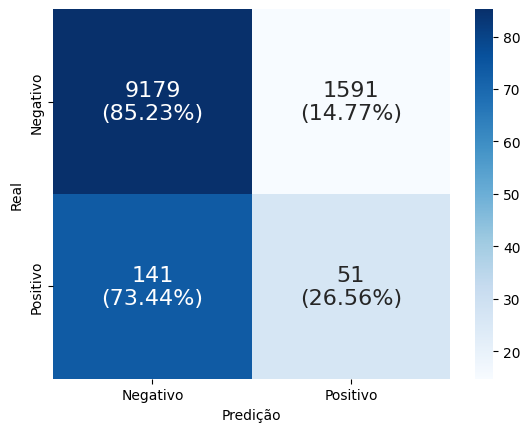

In [40]:
cm = confusion_matrix(test_features["y_label"].values, test_features["y_pred"].values)
cm_pct = confusion_matrix(test_features["y_label"].values, test_features["y_pred"].values, normalize = "true")

class_names = ['Negativo', 'Positivo']

ax = sns.heatmap(cm_pct*100, annot = True, fmt = '.2f', cmap = "Blues", annot_kws = {"size": 16},\
           xticklabels = class_names, yticklabels = class_names)

i=0
for t in ax.texts:
  t.set_text(str(cm.flatten()[i])+ "\n("+ t.get_text() + "%)")
  i = i+1

ax.set_xlabel("Predição")
ax.set_ylabel("Real")

## LightGBM

In [44]:

for i in range(1,20):
  model_l = LGBMClassifier(max_depth=i).fit(train_features_smote[predictors], train_features_smote[target])
  balanced_accuracy_score(validation_features_smote[target], model_l.predict(validation_features_smote[predictors]))

LGBMClassifier(max_depth=9)

In [45]:
val_predict = model_l.predict(validation_features_smote[predictors])
balanced_accuracy_score(validation_features_smote[target], val_predict)

0.790577787404929

In [46]:
test_predict = model_l.predict(test_features[predictors])
balanced_accuracy_score(test_features[target], test_predict)

0.5120299442896936

In [ ]:
hparameters = {
    'max_depth': [5, 10, 15, 20, 25]  #Maximum number of levels in each decision tree
    , 'n_estimators': [10, 50, 100] # Number of trees in the forest
}

# model = RandomForestClassifier()
# best_model = GridSearchCV(model, hparameters, cv = 5, scoring = 'balanced_accuracy', return_train_score=True, n_jobs = -1)
# best_model.fit(train_features_smote[predictors], train_features_smote[target])
# y_pred = best_model.predict(test_features[predictors])
print("RandomForestClassifier")
print("Acurácia Balanceada: %.4f" % balanced_accuracy_score(test_features[target], y_pred))

In [ ]:
# def modelfit(alg, dtrain, dval, dtest, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):

#     if useTrainCV:
#         xgb_param = alg.get_xgb_params()
#         xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
#         cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
#             metrics='auc', early_stopping_rounds=early_stopping_rounds)
#         alg.set_params(n_estimators=cvresult.shape[0])

#     #Fit the algorithm on the data
#     alg.fit(dtrain[predictors], dtrain[target], eval_metric='auc')

#     #Predict validation set:
#     dval_predictions = alg.predict(dval[predictors])
#     dval_predprob = alg.predict_proba(dval[predictors])[:,1]

#     #Print model report:
#     print("\nModel Report on: Validation Dataset")
#     print("Accuracy : %.4g" % accuracy_score(dval[target].values, dval_predictions))
#     print("Balanced Accuracy : %.4g" % balanced_accuracy_score(dval[target].values, dval_predictions))
#     print("AUC Score (Train): %f" % roc_auc_score(dval[target], dval_predprob))


#     #Predict Test set:
#     dtest_predictions = alg.predict(dtest[predictors])
#     dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]

#     #Print model report:
#     print("\nModel Report on: Test Dataset")
#     print("Accuracy : %.4g" % accuracy_score(dtest[target].values, dtest_predictions))
#     print("Balanced Accuracy : %.4g" % balanced_accuracy_score(dtest[target].values, dtest_predictions))
#     print("AUC Score (Train): %f" % roc_auc_score(dtest[target], dtest_predprob))

#     return dval_predictions, dtest_predictions

#     # feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
#     # feat_imp.plot(kind='bar', title='Feature Importances')
#     # plt.ylabel('Feature Importance Score')

In [ ]:
# param_test1 = {
# 'gamma':[i/10.0 for i in range(0,5)]
# }
# gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate = 0.1, n_estimators=1000, max_depth=13,
#                         min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
#                         objective= 'binary:logistic', nthread=4, scale_pos_weight=1, verbosity = 2, tree_method = "gpu_hist", seed=27),
#                         param_grid = param_test1, scoring='balanced_accuracy', n_jobs=4, cv=5)
# gsearch1.fit(train_features_smote[predictors], train_features_smote[target])
# gsearch1.best_params_, gsearch1.best_score_

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


({'gamma': 0.0}, 0.9996055109400395)

In [ ]:
#  for i in ['mean_test_score', 'std_test_score']:
#         print(i," : ",gsearch1.cv_results_[i])

mean_test_score  :  [0.99960551 0.9994448  0.99913798 0.99912337 0.99903571]
std_test_score  :  [8.76737250e-05 2.29149749e-04 4.09070822e-04 1.38623215e-04
 1.25644104e-04]


In [ ]:
# target = "y_label"
# predictors = [x for x in train_features_smote.columns if x not in [target]]

# xgb1 = xgb.XGBClassifier(learning_rate = 0.1,
#                         n_estimators=1000,
#                         max_depth=13,
#                         min_child_weight=1,
#                         gamma=0,
#                         subsample=0.8,
#                         colsample_bytree=0.8,
#                         objective = 'binary:logistic',
#                         nthread=4,
#                         scale_pos_weight=1,
#                         verbosity = 2,
#                         tree_method = "gpu_hist",
#                         seed=27)
# y_pred_val, y_pred_test = modelfit(xgb1, train_features_smote, validation_features_smote, test_features, predictors)